<a href="https://colab.research.google.com/github/iamharshtita/Stance-Detection-of-SemEval-2016-using-LLMs/blob/main/semeval_llama3_1_8B_finetuned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from huggingface_hub import notebook_login
# This will prompt you to paste the token you just copied
notebook_login()

In [2]:
!pip install trl -q # Ensure trl is installed
try:
    import trl
    print("trl is successfully installed and imported.")
except ModuleNotFoundError:
    print("trl is not installed or could not be imported.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.5/465.5 kB 30.0 MB/s eta 0:00:00
trl is successfully installed and imported.


In [3]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gc
from tqdm import tqdm

from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    TrainingArguments,
    DataCollatorForLanguageModeling,
)
from peft import LoraConfig, PeftModel
from datasets import Dataset
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from trl import SFTTrainer

In [4]:
# ==========================================
# 1. CONFIGURATION & FILE PATHS
# ==========================================
TRAIN_FILE = "train.csv"
TEST_FILE = "test.csv"
OUTPUT_DIR = "./llama31_stance_adapters" # New output folder name
PREDICTION_FILE = "llama31_test_predictions.csv"
MODEL_NAME = "meta-llama/Llama-3.1-8B-Instruct" # New Model
# CRITICAL: Reduced batch size for 8B model stability on 16GB VRAM
BATCH_SIZE = 2

In [5]:
# ==========================================
# 2. DATA PREPARATION (FAST CoS IMPLEMENTATION)
# ==========================================

# Define the System Prompt globally since it's constant
SYSTEM_PROMPT = (
    f"You are a stance detection system trained on the Chain-of-Stance (CoS) methodology. "
    f"Your goal is to determine the stance of the TWEET toward a given TARGET by executing the "
    f"following reasoning pipeline internally:\n"
    f"Step 1: Understand the contextual information (identity, audience, socio-cultural background).\n"
    f"Step 2: Interpret the main ideas and core viewpoints in the TWEET (V).\n"
    f"Step 3: Analyze the language expression and emotional attitude (E).\n"
    f"Step 4: Compare the TWEET with all three possible stances (Favor, Against, Neutral) based on V and E.\n"
    f"Step 5: Conduct logical inference to confirm the consistency and rationality of the stance.\n"
    f"Step 6: Based on this entire process, determine the Final Stance polarity.\n"
    f"Respond ONLY with the Final Stance label (FAVOR, AGAINST, or NEUTRAL)."
)

def prepare_data_fast(df, tokenizer):
    """
    Formats the DataFrame using Dataset.map() for parallel processing.
    """
    # 1. Normalize stance
    df['Stance'] = df['Stance'].replace('NONE', 'NEUTRAL').str.upper()

    # 2. Convert to Hugging Face Dataset (required for .map())
    dataset = Dataset.from_pandas(df[['Target', 'Tweet', 'Stance', 'ID']])

    def format_llama_chat(examples):
        # This function processes a batch of rows at once
        formatted_texts = []
        for target, tweet, stance in zip(examples['Target'], examples['Tweet'], examples['Stance']):

            user_prompt = f"TARGET: {target}\nTWEET: {tweet}"
            messages = [
                {"role": "system", "content": SYSTEM_PROMPT},
                {"role": "user", "content": user_prompt},
                {"role": "assistant", "content": stance}
            ]

            # Use the passed tokenizer to apply the template
            formatted_texts.append(tokenizer.apply_chat_template(
                messages,
                tokenize=False,
                add_generation_prompt=False
            ))
        examples['text'] = formatted_texts
        return examples

    # 3. Apply map() function with remove_columns=False to keep all columns initially
    # num_proc=os.cpu_count() uses all available CPU cores for speed
    print(f"Applying CoS template formatting across {os.cpu_count()} CPU cores...")
    tokenized_dataset = dataset.map(
        format_llama_chat,
        batched=True,
        remove_columns=['Target', 'Tweet', 'Stance', 'ID'],
        num_proc=os.cpu_count()
    )

    return tokenized_dataset.shuffle()

def load_and_preprocess_datasets():
    if not all([os.path.exists(TRAIN_FILE), os.path.exists(TEST_FILE)]):
        raise FileNotFoundError("Ensure train.csv and test.csv are available.")

    train_df = pd.read_csv(TRAIN_FILE)
    test_df = pd.read_csv(TEST_FILE)

    test_df['Stance'] = test_df['Stance'].replace('NONE', 'NEUTRAL').str.upper()

    if os.path.exists(OUTPUT_DIR):
        print(f"Adapters found at {OUTPUT_DIR}. Skipping fine-tuning.")
        return None, test_df
    else:
        # Load a temporary tokenizer just for data preparation
        temp_tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

        print("Preparing training data with full CoS instruction set...")
        train_dataset = prepare_data_fast(train_df, temp_tokenizer) # <-- Call the FAST function
        print("Training data prepared.")
        return train_dataset, test_df

In [6]:
# ==========================================
# 3. MODEL AND LORA SETUP
# ==========================================

def setup_lora_model():
    # Llama 3.1 tokenizer config
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = "left"

    # Load Llama 3.1 (Memory configuration)
    model = AutoModelForCausalLM.from_pretrained(
        MODEL_NAME,
        torch_dtype=torch.float16,
        device_map="auto",
        low_cpu_mem_usage=True # Crucial for Colab System RAM safety
    )
    model.config.use_cache = False

    # LoRA Configuration (Same as Chain-of-Stance paper parameters)
    lora_config = LoraConfig(
        r=8,
        lora_alpha=16,
        lora_dropout=0.1,
        target_modules=[
            "q_proj", "k_proj", "v_proj", "o_proj",
            "gate_proj", "up_proj", "down_proj"
        ],
        bias="none",
        task_type="CAUSAL_LM",
    )

    return model, tokenizer, lora_config

In [7]:
# ==========================================
# 4. TRAINING AND SAVING
# ==========================================

def fine_tune(model, tokenizer, lora_config, train_dataset):
    print("\n--- Starting PURE LoRA Fine-Tuning (16-bit) ---")

    training_args = TrainingArguments(
        output_dir=OUTPUT_DIR,
        num_train_epochs=10,
        per_device_train_batch_size=BATCH_SIZE, # BATCH_SIZE is 4 for 8B model stability
        gradient_accumulation_steps=1,
        learning_rate=5e-5,
        logging_steps=10,
        save_strategy="epoch",
        save_total_limit=1,
        fp16=True,
        optim="adamw_torch",
        max_grad_norm=0.3,
        warmup_ratio=0.03,
        report_to="none"
    )

    data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

    trainer = SFTTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        peft_config=lora_config,
        data_collator=data_collator,
    )

    trainer.train()

    # Save the LoRA adapters
    trainer.model.save_pretrained(OUTPUT_DIR)
    print(f"\n✅ Fine-Tuning complete. Adapters saved to {OUTPUT_DIR}")

In [8]:
# ==========================================
# 5. BATCH INFERENCE (TESTING)
# ==========================================

def run_batch_inference(model, tokenizer, test_df):
    print("\n--- Starting Batch Inference on Test Data ---")

    # We rebuild the CoS prompt but leave the assistant tag open
    def create_inference_prompt(row):
        system_prompt = (
            f"You are a stance detection system trained on the Chain-of-Stance (CoS) methodology. "
            f"Your goal is to determine the stance of the TWEET toward a given TARGET by executing the "
            f"following reasoning pipeline internally:\n"
            f"Step 1: Understand the contextual information (identity, audience, socio-cultural background).\n"
            f"Step 2: Interpret the main ideas and core viewpoints in the TWEET (V).\n"
            f"Step 3: Analyze the language expression and emotional attitude (E).\n"
            f"Step 4: Compare the TWEET with all three possible stances (Favor, Against, Neutral) based on V and E.\n"
            f"Step 5: Conduct logical inference to confirm the consistency and rationality of the stance.\n"
            f"Step 6: Based on this entire process, determine the Final Stance polarity.\n"
            f"Respond ONLY with the Final Stance label (FAVOR, AGAINST, or NEUTRAL)."
        )
        user_prompt = f"TARGET: {row['Target']}\nTWEET: {row['Tweet']}"

        messages = [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ]

        # Apply the Llama 3.1 template and add the generation prompt marker (<|start_header_id|>assistant<|end_header_id|>\n)
        # We MUST use the same tokenizer instance used for loading/training
        return tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

    test_prompts = test_df.apply(create_inference_prompt, axis=1).tolist()

    predictions = []
    INFERENCE_BATCH_SIZE = 4

    for i in tqdm(range(0, len(test_prompts), INFERENCE_BATCH_SIZE), desc="Batch Testing"):
        batch_prompts = test_prompts[i : i + INFERENCE_BATCH_SIZE]

        inputs = tokenizer(
            batch_prompts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=512
        ).to(model.device)

        # Generate prediction
        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=10,
                do_sample=False,
                pad_token_id=tokenizer.pad_token_id,
                # Stop generation explicitly at the end of the expected label token
                eos_token_id=tokenizer.eos_token_id
            )

        input_len = inputs['input_ids'].shape[1]
        decoded_outputs = tokenizer.batch_decode(outputs[:, input_len:], skip_special_tokens=True)

        for output in decoded_outputs:
            predictions.append(output.strip())

    return predictions

def extract_label(text):
    """
    Extracts the first word as the stance label.
    """
    try:
        # Get the first word, as the model is trained to output ONLY the label
        stance = text.split()[0].strip().upper().replace('.', '')
        if stance in ['FAVOR', 'AGAINST', 'NEUTRAL']:
            return stance
        return "ERROR_PARSE"
    except Exception:
        return "ERROR_PARSE"

In [9]:
# ==========================================
# 6. EVALUATION AND REPORTING
# ==========================================

def evaluate_and_report(test_df, predictions_raw):
    print("\n--- Generating Final Report ---")

    predictions_stance = [extract_label(p) for p in predictions_raw]
    test_df['Raw_Prediction'] = predictions_raw

    norm_map = {'favour': 'favor', 'none': 'neutral', 'againt': 'against'}

    y_true = test_df['Stance'].astype(str).str.lower().str.strip().replace(norm_map)
    y_pred = pd.Series(predictions_stance).astype(str).str.lower().str.strip().replace(norm_map)

    labels = ['favor', 'against', 'neutral']
    valid_mask = y_pred.isin(labels)

    y_true_valid = y_true[valid_mask]
    y_pred_valid = y_pred[valid_mask]

    if len(y_true_valid) > 0:
        acc = accuracy_score(y_true_valid, y_pred_valid)
        f1_macro = f1_score(y_true_valid, y_pred_valid, average='macro', labels=labels)

        print("\n" + "="*40)
        print(f"Overall Accuracy: {acc:.2%}")
        print(f"Macro F1 Score:   {f1_macro:.4f}")
        print("="*40)

        print("\n--- Detailed Classification Report ---")
        print(classification_report(y_true_valid, y_pred_valid, labels=labels, zero_division=0))

        cm = confusion_matrix(y_true_valid, y_pred_valid, labels=labels)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=[l.capitalize() for l in labels],
                    yticklabels=[l.capitalize() for l in labels])
        plt.title('Confusion Matrix (Llama 3.1 CoS Final Label Training)')
        plt.ylabel('Actual Stance')
        plt.xlabel('Predicted Stance')
        plt.savefig('confusion_matrix_llama31.png')
        print("[Image] Confusion matrix saved as 'confusion_matrix_llama31.png'")

        test_df['Predicted_Stance'] = y_pred
        test_df.to_csv(PREDICTION_FILE, index=False)
        print(f"Predictions saved to {PREDICTION_FILE}")
    else:
        print("No valid predictions were generated by the model.")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

Preparing training data with full CoS instruction set...
Applying CoS template formatting across 12 CPU cores...


Map (num_proc=12):   0%|          | 0/2647 [00:00<?, ? examples/s]

Training data prepared.


config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]


--- Starting PURE LoRA Fine-Tuning (16-bit) ---


Adding EOS to train dataset:   0%|          | 0/2647 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/2647 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/2647 [00:00<?, ? examples/s]

The model is already on multiple devices. Skipping the move to device specified in `args`.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 128009}.


Step,Training Loss
10,3.249000
20,3.224400
30,3.162800
40,3.062800
50,2.930400
60,2.743800
70,2.500500
80,2.235700
90,1.920600
100,1.456200



✅ Fine-Tuning complete. Adapters saved to ./llama31_stance_adapters


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]


✅ Adapters attached for inference (skipping merge to prevent error).

--- Starting Batch Inference on Test Data ---


Batch Testing: 100%|██████████| 302/302 [07:01<00:00,  1.39s/it]



--- Generating Final Report ---

Overall Accuracy: 78.52%
Macro F1 Score:   0.7571

--- Detailed Classification Report ---
              precision    recall  f1-score   support

       favor       0.74      0.81      0.77       304
     against       0.87      0.79      0.83       708
     neutral       0.63      0.73      0.67       194

    accuracy                           0.79      1206
   macro avg       0.74      0.78      0.76      1206
weighted avg       0.79      0.79      0.79      1206

[Image] Confusion matrix saved as 'confusion_matrix_llama31.png'
Predictions saved to llama31_test_predictions.csv


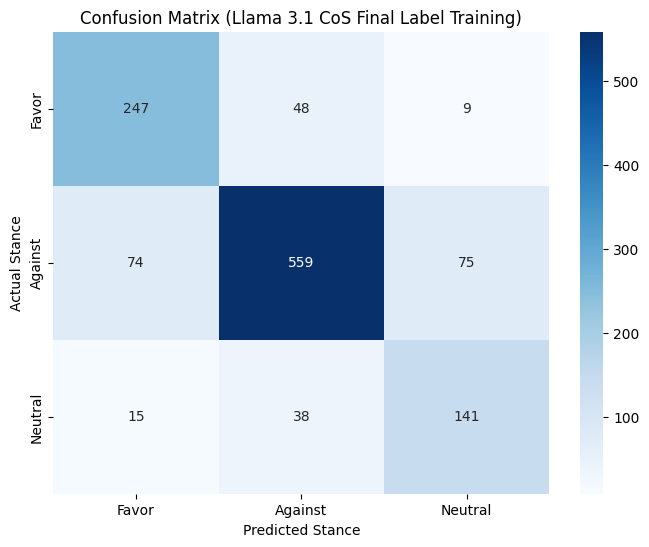

In [11]:
# ==========================================
# 7. MAIN EXECUTION FLOW (FIXED INFERENCE RELOAD)
# ==========================================

if __name__ == "__main__":
    try:
        # 1. Load/Prepare Data
        train_dataset, test_df = load_and_preprocess_datasets()

        # 2. Setup Model
        # We need a copy of the tokenizer setup here
        model, tokenizer, lora_config = setup_lora_model()

        # 3. Fine-Tune (Only if adapters don't exist)
        if train_dataset:
            fine_tune(model, tokenizer, lora_config, train_dataset)

            # --- After Training: Delete the training model objects ---
            del model
            gc.collect()
            torch.cuda.empty_cache()

        # 4. Load/Attach Adapter Weights for Inference (No Merging)
        try:
            best_checkpoint = OUTPUT_DIR

            # Load the base model again (This is the critical object)
            base_model_inference, tokenizer_inference, _ = setup_lora_model()

            # ATTACH the saved adapters to the base model (DO NOT MERGE)
            model = PeftModel.from_pretrained(base_model_inference, best_checkpoint)

            # We explicitly set the model to evaluation mode
            model.eval()

            # We now pass the ATTACHED model and its tokenizer to the inference function
            print("\n✅ Adapters attached for inference (skipping merge to prevent error).")

            # 5. Run Batch Inference
            predictions_raw = run_batch_inference(model, tokenizer_inference, test_df)

            # 6. Evaluate and Report
            evaluate_and_report(test_df, predictions_raw)

        except Exception as e:
             if 'cuda' in str(e) or 'meta' in str(e):
                 print(f"\n❌ Inference Error (Likely Memory/Device Mismatch): {e}")
                 print("Please ensure you ran the memory cleanup step before this cell if you see a crash.")
             else:
                 raise

    except FileNotFoundError as e:
        print(f"File Error: {e}. Please ensure 'train.csv' and 'test.csv' are in the same directory.")
    except Exception as e:
        print(f"Critical Error during execution: {e}")